# Libs

In [1]:
import pandas as pd
import numpy as np
import gc 
from tqdm import tqdm

# Funcs

In [2]:



class AGG_DATA():
    def __init__(self, path_data):
        """
        path_data: dictionary
        """
        self.path_data = path_data
        
    
    def one_hot_encoder(self, df, nan_as_category = True):
        original_columns = list(df.columns)
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
        df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
        new_columns = [c for c in df.columns if c not in original_columns]
        return df, new_columns

    def grab_col_names(self, dataframe, cat_th=10, car_th=20):
        # cat_cols, cat_but_car
        cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
        num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                       dataframe[col].dtypes != "O"]
        cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                       dataframe[col].dtypes == "O"]
        cat_cols = cat_cols + num_but_cat
        cat_cols = [col for col in cat_cols if col not in cat_but_car]

        # num_cols
        num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
        num_cols = [col for col in num_cols if col not in num_but_cat]

        return cat_cols, num_cols, cat_but_car

    # Rare Encoding
    def rare_encoder(self, dataframe, rare_perc, cat_cols):

        rare_columns = [col for col in cat_cols if
                        (dataframe[col].value_counts() / len(dataframe) < rare_perc).sum() > 1]

        for col in rare_columns:
            tmp = dataframe[col].value_counts() / len(dataframe)
            rare_labels = tmp[tmp < rare_perc].index
            dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])

        return dataframe
    
    def iv_woe(self, data, target, bins=10, show_woe=False):

        #Empty Dataframe
        newDF,woeDF = pd.DataFrame(), pd.DataFrame()

        #Extract Column Names
        cols = data.columns

        #Run WOE and IV on all the independent variables
        for ivars in cols[~cols.isin([target])]:
    #     for ivars in ['AMT_REQ_CREDIT_BUREAU_YEAR']:
            if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
                binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
                d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
            else:
                d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

            # missing
            if d0.isnull().sum().sum() > 0 :
                try:
                    d0['x'] = d0['x'].cat.add_categories('Missing')
                    d0['x'].fillna('Missing', inplace =True)
                except:
    #                 print('var ', ivars)
                    d0['x'].fillna('Missing', inplace =True)


            # Calculate the number of events in each group (bin)
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']

            # Calculate % of events in each group.
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

            # Calculate the non events in each group.
            d['Non-Events'] = d['N'] - d['Events']
            # Calculate % of non events in each group.
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

            # Calculate WOE by taking natural log of division of % of non-events and % of events
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            d.insert(loc=0, column='Variable', value=ivars)
    #         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
            temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
            newDF=pd.concat([newDF,temp], axis=0)
            woeDF=pd.concat([woeDF,d], axis=0)

            #Show WOE Table
            if show_woe == True:
                print(d)
        return newDF, woeDF
    
    ## agg: install 
    def installments_payments(self, nan_as_category = True):
        df = pd.read_csv(self.path_data['installments_payments'])
        cat_cols, num_cols, cat_but_car = self.grab_col_names(df)
        df, cat_cols = self.one_hot_encoder(df, nan_as_category= True) ### neden cat var?



        # The difference between the amount paid in each loan installment payment and the original and its percentage
        df['PAYMENT_PERC'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT']
        df['PAYMENT_DIFF'] = df['AMT_INSTALMENT'] - df['AMT_PAYMENT']

       # Days overdue and days before due -- only positive values are taken
        df['DPD'] = df['DAYS_ENTRY_PAYMENT'] - df['DAYS_INSTALMENT']
        df['DBD'] = df['DAYS_INSTALMENT'] - df['DAYS_ENTRY_PAYMENT']
        df['DPD'] = df['DPD'].apply(lambda x: x if x > 0 else 0)
        df['DBD'] = df['DBD'].apply(lambda x: x if x > 0 else 0)

        # Whether each installment payment is late or not 1: late paid 0: represents early payment
        df['NEW_DAYS_PAID_EARLIER'] = df['DAYS_INSTALMENT'] - df['DAYS_ENTRY_PAYMENT']
        df['NEW_NUM_PAID_LATER'] = df['NEW_DAYS_PAID_EARLIER'].map(lambda x: 1 if x<0 else 0)

        # Numeric Features
        aggregations = {
            'NUM_INSTALMENT_VERSION': ['nunique'],
            'DPD': ['max', 'mean', 'sum'],
            'DBD': ['max', 'mean', 'sum'],
            'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
            'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
            'AMT_INSTALMENT': ['max', 'mean', 'sum'],
            'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
            'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
        }

        # Categorical Features
        for cat in cat_cols:
            aggregations[cat] = ['mean']
        ins_agg = df.groupby('SK_ID_CURR').agg(aggregations)
        ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
        # Count installments accounts
        ins_agg['INSTAL_COUNT'] = df.groupby('SK_ID_CURR').size()
        del df
        gc.collect()
        #print(ins_agg.columns.tolist())
        return ins_agg
    
    # application
    def previous_application(self, nan_as_category = True):
        df = pd.read_csv(self.path_data['previous_application'])
        cat_cols, num_cols, cat_but_car = self.grab_col_names(df)

        df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
        df['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
        df['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
        df['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
        df['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)



        na = ['XNA', 'XAP']
        for col in cat_cols:
            for n in na:
                df.loc[df[col] == n, col] = np.nan

        self.rare_encoder(df, 0.01,cat_cols)



        a = ['Auto Accessories', 'Jewelry', 'Homewares', 'Medical Supplies', 'Vehicles', 'Sport and Leisure', 
             'Gardening', 'Other', 'Office Appliances', 'Tourism', 'Medicine', 'Direct Sales', 'Fitness', 'Additional Service', 
             'Education', 'Weapon', 'Insurance', 'House Construction', 'Animals'] 

        df["NAME_GOODS_CATEGORY"] = df["NAME_GOODS_CATEGORY"].replace(a, 'others')

        # "NAME_SELLER_INDUSTRY
        df["NAME_SELLER_INDUSTRY"] = df["NAME_SELLER_INDUSTRY"].replace("Rare", 'others')

        # PREV_NAME_GOODS_CATEGORY
        df["NAME_GOODS_CATEGORY"] = np.where(df["NAME_GOODS_CATEGORY"].str.contains("Photo / Cinema Equipment"),
                                           "Photo_Cinema_Equipment", df["NAME_GOODS_CATEGORY"])

        # CHANNEL_TYPE
        df["CHANNEL_TYPE"] = np.where(df["CHANNEL_TYPE"].str.contains("Regional / Local"),
                                           "Regional_Local", df["CHANNEL_TYPE"])

        df["NAME_GOODS_CATEGORY"] = np.where(df["NAME_GOODS_CATEGORY"].str.contains("Audio/Video"),
                                           "Audio_Video", df["NAME_GOODS_CATEGORY"])




        del_cols = ['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_FIRST_DRAWING',
                    'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'FLAG_LAST_APPL_PER_CONTRACT',
                    'NFLAG_LAST_APPL_IN_DAY', 'SELLERPLACE_AREA']

        df.drop(del_cols, axis=1, inplace=True)



        df["NEW_HOUR_APPR_PROCESS_START_CAT"]= df.loc[:,"HOUR_APPR_PROCESS_START"]
        a = [8,9,10,11,12,13,14,15,16,17]
        df["NEW_HOUR_APPR_PROCESS_START_CAT"] = df["NEW_HOUR_APPR_PROCESS_START_CAT"].replace(a, "WORK_HOURS")
        b = [18,19,20,21,22,23,0,1,2,3,4,5,6,7]
        df["NEW_HOUR_APPR_PROCESS_START_CAT"] = df["NEW_HOUR_APPR_PROCESS_START_CAT"].replace(b, 'OFF_HOURS')

        # 2. "WEEKDAY_APPR_PROCESS_START" We have reduced the variable to two classes as WEEK_DAY and WEEKEND
        df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"] = df.loc[:,"WEEKDAY_APPR_PROCESS_START"]
        df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"] = df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"].replace(['MONDAY','TUESDAY', 'WEDNESDAY','THURSDAY','FRIDAY'], 'WEEK_DAY')
        df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"] = df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"].replace(['SATURDAY', 'SUNDAY'], 'WEEKEND')

        # 3. "NAME_TYPE_SUITE"  dividing the variable into two categories as single and multiple
        df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].replace('Unaccompanied', 'single')
        b = ['Family', 'Spouse, partner', 'Children', 'Other_B', 'Other_A', 'Group of people']
        df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].replace(b, 'multiple')

        # 4. How much credit did the client request in the previous application / final credit amount of the previous application
        df["NEW_AMT_CREDIT_RATIO"] = df["AMT_APPLICATION"]/df["AMT_CREDIT"]

        # Having less than the desired credit, which should be close to 1
        # Having more than the desired credit, which should be close to 0
        # If 1, the loan amount requested and the loan amount must be the same.

        # 5. If x <= 1, he got the loan he wanted or more.
        df["NEWX2_FLAG_AMT_CREDIT_RATIO"] = df["NEW_AMT_CREDIT_RATIO"].apply(lambda x: 1 if(x<=1) else 0)



        df[(df['AMT_CREDIT'] == 0) | (df['AMT_GOODS_PRICE'] == 0)]['NEW_INSURED_ON_APPROVAL'] = np.nan
        df['INSURANCE_AMOUNT'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
        df['NEW_INSURED_ON_APPROVAL'] = df['INSURANCE_AMOUNT'].apply(lambda x: 1 if x > 0 else (0 if x <= 0 else np.nan))
        df.drop('INSURANCE_AMOUNT', axis=1, inplace=True)

        # 7. How many years did he pay = Amount of loan / annual installment given by the bank
        df['NEW_HOW_PAID_YEARS'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

       # 8. The amount of loan he applied for / the price of the product he wants to buy
        df['NEW_GOODS_RATIO'] = df['AMT_APPLICATION'] / df['AMT_GOODS_PRICE']


        df['NEW_LATE_DAYS'] =  df['DAYS_LAST_DUE_1ST_VERSION'] - df['DAYS_FIRST_DUE'] 

        # 10 .CLASSIFIED ONE
        k = df["DAYS_LAST_DUE_1ST_VERSION"] - df["DAYS_LAST_DUE"]
        df["NEW_FLAG_LATE_DAYS"] = [1 if i >= 0 else (0 if i < 0  else "NaN") for i in k]

       # WEEKDAY_APPR_PROCESS_START_DIC
       # Cycle encoding can be used in cyclic variables such as day, month, year.
        df['WEEKDAY_APPR_PROCESS_START_DIC'] = df['WEEKDAY_APPR_PROCESS_START'].map({
            'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7})
        df['NEW_WEEKDAY_SIN'] = np.sin(2 * np.pi * df['WEEKDAY_APPR_PROCESS_START_DIC'] / 7)
        df['NEW_WEEKDAY_COS'] = np.cos(2 * np.pi * df['WEEKDAY_APPR_PROCESS_START_DIC'] / 7)



        df, cat_cols = self.one_hot_encoder(df, nan_as_category= True)


        col_list = df.columns.tolist()
        id_list = ["SK_ID_CURR","SK_ID_PREV"]
        num_list = [col for col in col_list if col not in cat_cols + id_list]

        # Previous applications numeric features
        agg_num_prev = {}
        for num in num_list:
            agg_num_prev[num] = ['min', 'max', 'mean', 'median']

        # Previous applications categorical features
        agg_cat_prev = {}
        for cat in cat_cols:
            agg_cat_prev[cat] = ['mean']

        prev_agg = df.groupby('SK_ID_CURR').agg({**agg_num_prev, **agg_cat_prev})
        prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

        # Previous Applications: Approved Applications - only numerical features
        approved = df[df['NAME_CONTRACT_STATUS_Approved'] == 1]
        approved_agg = approved.groupby('SK_ID_CURR').agg(agg_num_prev)
        approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
        prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

        # Previous Applications: Refused Applications - only numerical features
        refused = df[df['NAME_CONTRACT_STATUS_Refused'] == 1]
        refused_agg = refused.groupby('SK_ID_CURR').agg(agg_num_prev)
        refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
        prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

        del refused, refused_agg, approved, approved_agg, df
        gc.collect()
        #print(prev_agg.columns.tolist())
        return prev_agg
    
    
    def credit_card_balance(self, nan_as_category = True):
        df = pd.read_csv(self.path_data['credit_card_balance'])
        cat_cols, num_cols, cat_but_car = self.grab_col_names(df)

        # Rare
        df["NAME_CONTRACT_STATUS"] = np.where(~(df["NAME_CONTRACT_STATUS"].isin(["Active", "Completed"])),
                                              "Rare", df["NAME_CONTRACT_STATUS"])

        # One Hot Encoder
        df, cat_cols = self.one_hot_encoder(df, nan_as_category=False)


        # Amount withdrawn from ATM + amount of goods purchase
        df["TOTAL_SPENDING"] = df["AMT_DRAWINGS_ATM_CURRENT"] + df["AMT_DRAWINGS_POS_CURRENT"]

        # The amount paid by the customer during the month - the minimum monthly installment
        df["REGULARITY_PAYMENT"] = df["AMT_INST_MIN_REGULARITY"] - df["AMT_PAYMENT_TOTAL_CURRENT"]

        # General aggregations
        df.drop(['SK_ID_PREV'], axis= 1, inplace = True)
        cc_agg = df.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
        cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
        # Count credit card lines
        cc_agg['CC_COUNT'] = df.groupby('SK_ID_CURR').size()
        del df
        gc.collect()
        return cc_agg
    
    def agg_pos_cash_time(self, time, nan_as_category = True):
        df = pd.read_csv(self.path_data['POS_CASH_balance'])
        if time != 'full':
            df = df[df['MONTHS_BALANCE'] >= -time]
        cat_cols, num_cols, cat_but_car = self.grab_col_names(df)

        # Rare
        self.rare_encoder(df, 0.01, cat_cols)
        # One-Hot Encoding
        df, cat_cols = self.one_hot_encoder(df, nan_as_category= True)

        # Numerical Features
        aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'],
                        'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
                        'CNT_INSTALMENT_FUTURE': ['max', 'mean', 'sum', 'min', 'median', 'std'],
                        'SK_DPD': ['max', 'mean', 'sum'],
                        'SK_DPD_DEF': ['max', 'mean', 'sum']
                       }
    
        # Categorical Features
        original_columns = list(df.columns)
        new_columns = [c for c in df.columns if c not in original_columns]
        for cat in new_columns:
            aggregations[cat] = ['mean']

        pos_agg = df.groupby('SK_ID_CURR').agg(aggregations)
        pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() + '_C{}'.format(time) for e in pos_agg.columns.tolist()])
        # Count pos cash accounts
        pos_agg['POS_COUNT'] = df.groupby('SK_ID_CURR').size()
        del df
        gc.collect()
        #print(pos_agg.columns.tolist())
        return pos_agg
    
    
    def agg_bureau_and_balance(self, nan_as_category = True):
        df = pd.read_csv(self.path_data['bureau_balance'])
        bureau = pd.read_csv(self.path_data['bureau'])

        df,df_cat=self.one_hot_encoder(df)

        # Bureau balance: Perform aggregations and merge with bureau.csv
        agg_list = {'MONTHS_BALANCE': ['min', 'max', 'size'] }
        for col in df_cat:
            agg_list[col] = ['mean','sum']

        bb_agg = df.groupby("SK_ID_BUREAU").agg(agg_list)
        # Renaming variable names
        bb_agg.columns = pd.Index([col[0] + "_" + col[1].upper() for col in bb_agg.columns.tolist()])
        # New feature
        bb_agg['NEW_STATUS_SCORE'] = bb_agg['STATUS_1_SUM'] + bb_agg['STATUS_2_SUM']^2 + bb_agg['STATUS_3_SUM']^3 + bb_agg['STATUS_4_SUM']^4 + bb_agg['STATUS_5_SUM']^5

        bureau_and_bb = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
        bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
        del df, bb_agg
        gc.collect()

        cat_cols, num_cols, cat_but_car = self.grab_col_names(bureau_and_bb)
        self.rare_encoder(bureau_and_bb,0.2,cat_cols)

        #CREDIT_ACTIVE reduced the number of classes of variable to 2 (Closed-Active)
        bureau_and_bb['CREDIT_ACTIVE'] = bureau_and_bb['CREDIT_ACTIVE'].replace("Rare", 'Active')
        #CREDIT_CURRENCY The 1 class of the variable carries meaningless information because it covers 99% of the data set, that is, it is unbalanced data. Therefore, we will remove it.
        bureau_and_bb.drop("CREDIT_CURRENCY", inplace = True, axis = 1)


        bureau_and_bb.loc[(bureau_and_bb['CREDIT_ACTIVE'] == 'Active') & (bureau_and_bb['DAYS_CREDIT_ENDDATE'] < 0), 'NEW_EARLY_ACTİVE'] = 1
        bureau_and_bb.loc[(bureau_and_bb['CREDIT_ACTIVE'] == 'Closed') & (abs(bureau_and_bb['DAYS_CREDIT_ENDDATE']) < abs(bureau_and_bb['DAYS_ENDDATE_FACT']) ), 'NEW_EARLY_CLOSED'] = 1

        # 2. Replacing Extended Credits by 1
        bureau_and_bb["NEW_CNT_CREDIT_PROLONG_CAT"] = bureau_and_bb.loc[:,'CNT_CREDIT_PROLONG']
        prolong = [1,2,3,4,5,6,7,8,9]
        bureau_and_bb["NEW_CNT_CREDIT_PROLONG_CAT"] = bureau_and_bb['NEW_CNT_CREDIT_PROLONG_CAT'].replace(prolong, 1)

        # 3. How many different loan types did the person receive?
        temp_bu = bureau_and_bb[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'NEW_BUREAU_LOAN_TYPES'})
        bureau_and_bb = bureau_and_bb.merge(temp_bu, on=['SK_ID_CURR'], how='left')

        # 4. Debt Ratio
        # Current loan to Credit Bureau / current loan to the credit bureau
        # The reason for adding by 1 is not to be undefined.
        bureau_and_bb['NEW_DEPT_RATIO'] = bureau_and_bb['AMT_CREDIT_SUM_DEBT'] / (bureau_and_bb['AMT_CREDIT_SUM']+1)

        # 5.Is the credit update new?
        # We are based on 90 days. Because the transaction is started after 3 months delay in banks.
        bureau_and_bb['NEWS_DAYS_CREDIT_UPDATE'] = bureau_and_bb['DAYS_CREDIT_UPDATE'].apply(lambda x : 'old' if x < -90 else 'new')


        bureau_and_bb, bureau_and_bb_cat = self.one_hot_encoder(bureau_and_bb)

        # Bureau and bureau_balance numeric features
        num_aggregations = {'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
                            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
                            'DAYS_CREDIT_UPDATE': ['mean'],
                            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
                            'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
                            'NEW_STATUS_SCORE':['min','mean','max'],
                            'AMT_CREDIT_MAX_OVERDUE': ['mean'],
                            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
                            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
                            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
                            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
                            'AMT_ANNUITY': ['max', 'mean'],
                            'CNT_CREDIT_PROLONG': ['sum'],
                            'MONTHS_BALANCE_MIN': ['min'],
                            'MONTHS_BALANCE_MAX': ['max'],
                            'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
                            'NEW_DEPT_RATIO': ['min','max','mean'] }

        # Bureau and bureau_balance categorical features
        cat_aggregations = {}
        for cat in bureau_and_bb_cat: cat_aggregations[cat] = ['mean']
        for cat in df_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

        bureau_agg = bureau_and_bb.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
        bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

        # Bureau: Active credits - using only numerical aggregations
        active = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Active'] == 1]
        active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
        del active, active_agg

        # Bureau: Closed credits - using only numerical aggregations
        closed = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Closed'] == 1]
        closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
        del closed, closed_agg, bureau
        gc.collect()
        #print(bureau_agg.columns.tolist())
        return bureau_agg
    
    
    def agg_application_train(self, nan_as_category = False):
    
        # Reading the Dataset
        df = pd.read_csv(self.path_data['application_train'])
#         test_df = pd.read_csv('../input/home-credit-default-risk/application_test.csv', nrows= num_rows)
#         print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
#         df = df.append(test_df).reset_index()

        # There are 4 people whose gender is not specified, we remove them.
        df = df[df['CODE_GENDER'] != 'XNA']

        # There is 1 person whose marital status is unknown, we dropped it.
        df = df[df['NAME_FAMILY_STATUS'] != "Unknown" ]

        # NaN values for DAYS_EMPLOYED: 365243 -> nan
        df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)



        df.loc[df['NAME_INCOME_TYPE'] == 'Businessman', 'NAME_INCOME_TYPE'] = 'Commercial associate'
        df.loc[df['NAME_INCOME_TYPE'] == 'Maternity leave', 'NAME_INCOME_TYPE'] = 'Pensioner'
        df.loc[df['NAME_INCOME_TYPE'] == 'Student', 'NAME_INCOME_TYPE'] = 'State servant'
        df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Pensioner'

        # ORGANIZATION_TYPE
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Business Entity"), 
                                           "Business_Entity", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Industry"), 
                                           "Industry", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Trade"),
                                           "Trade", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Transport"),
                                           "Transport", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["School", "Kindergarten", "University"]),
                                           "Education", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Emergency","Police", "Medicine","Goverment", "Postal", "Military", "Security Ministries", "Legal Services"]), "Official", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Bank", "Insurance"]),
                                           "Finance", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Goverment"), 
                                           "Government", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Realtor", "Housing"]), "Realty", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Hotel", "Restaurant","Services"]), "TourismFoodSector", df["ORGANIZATION_TYPE"])
        df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Cleaning","Electricity", "Telecom", "Mobile", "Advertising", "Religion", "Culture"]), "Other", df["ORGANIZATION_TYPE"])


        # OCCUPATION_TYPE
        df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["Low-skill Laborers", "Cooking staff", "Security staff", "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low_skill_staff", df["OCCUPATION_TYPE"])
        df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["IT staff", "High skill tech staff"]), "High_skill_staff", df["OCCUPATION_TYPE"])
        df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["Secretaries", "HR staff","Realty agents"]), "Others", df["OCCUPATION_TYPE"])

        # NAME_TYPE_SUITE
        rare_list = ["NAME_TYPE_SUITE"]
        self.rare_encoder(df, 0.01, rare_list)



        df["NAME_EDUCATION_TYPE"] = np.where(df["NAME_EDUCATION_TYPE"] == "Academic degree",
                                             "Higher education", df["NAME_EDUCATION_TYPE"])

        df["NAME_EDUCATION_TYPE"] = np.where(df["NAME_EDUCATION_TYPE"].str.contains("Secondary / secondary special"),
                                             "Secondary_secondary_special", df["ORGANIZATION_TYPE"])

        # NAME_FAMILY_STATUS
        df["NAME_FAMILY_STATUS"] = np.where(df["NAME_FAMILY_STATUS"].str.contains("Single / not married"),
                                            "Single_not_married", df["NAME_FAMILY_STATUS"])


        # NAME_HOUSING_TYPE
        df["NAME_HOUSING_TYPE"] = np.where(df["NAME_HOUSING_TYPE"].str.contains("House / apartment"),
                                           "House_apartment", df["NAME_HOUSING_TYPE"])

        # NAME_TYPE_SUITE
        df["NAME_TYPE_SUITE"] = np.where(df["NAME_TYPE_SUITE"].str.contains("Spouse, partner"),
                                           "Spouse_partner", df["NAME_TYPE_SUITE"])


        # NAME_CONTRACT_TYPE
        # We have binary encoded variables that are categorical but will be encoded as 0 and 1, such as gender.
        for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
            df[bin_feature], uniques = pd.factorize(df[bin_feature])



        weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
        df.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
        # Cycle encode
        df['NEW_WEEKDAY_APPR_PROCESS_START' + "_SIN"] = np.sin(2 * np.pi * df["WEEKDAY_APPR_PROCESS_START"]/7)
        df["NEW_WEEKDAY_APPR_PROCESS_START" + "_COS"] = np.cos(2 * np.pi * df["WEEKDAY_APPR_PROCESS_START"]/7)



        df['NEW_HOUR_APPR_PROCESS_START' + "_SIN"] = np.sin(2 * np.pi * df["HOUR_APPR_PROCESS_START"]/23)
        df["NEW_HOUR_APPR_PROCESS_START" + "_COS"] = np.cos(2 * np.pi * df["HOUR_APPR_PROCESS_START"]/23)



        drop_cols = ["FONDKAPREMONT_MODE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
                     "EMERGENCYSTATE_MODE","FLAG_MOBIL", "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
        df.drop(drop_cols, axis = 1, inplace = True)

        df.drop(['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'], axis = 1, inplace = True)



        cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", 
                "REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
        df["NEW_REGION"] = df[cols].sum(axis = 1)
        df.drop(cols, axis = 1, inplace = True)


        docs = [col for col in df.columns if 'FLAG_DOC' in col]
        df['NEW_DOCUMENT'] = df[docs].sum(axis=1)
        df.drop(docs, axis = 1, inplace = True)



        # 1. How long ago did the client start working (days) / client's age (days)
        df['NEW_DAYS_EMPLOYED_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

        # 2. Customer's total income / loan amount
        df['NEW_INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

        # 3. Customer's total income / family member time
        # It reveals how much income per person in the family has.
        df['NEW_INCOME_PER_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

        # 4. Annual payment of the loan / Income of the customer
        # If this value is between 0-1, it is good, that is, the income is more than the loan payment.
        # If this value is 1, it is bad, that is, his income is less than the loan payment.
        df['NEW_ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

        # 5. Annual payment of the loan / loan amount
        df['NEW_PAYMENT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

        # 6. EXT_SOURCE variables were the scores taken from the outside. We created a new variable with their average.
        df["NEW_EXTSOURCE_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

        # 7. We created a new weighted variable by multiplying these variables.
        df['NEW_EXTSOURCES_WPOINT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

        # 8. Price of goods to be purchased with credit / total credit amount
        # If this ratio is between 0-1, it means that the customer takes more credit than the price of the goods they will buy.
        # If this ratio is 1, it means that the customer receives as much credit as he needs.
        # If this ratio is greater than 1, it means that the customer has taken less credit than he needs.
        df["NEW_GOODS_CREDIT_RATIO"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

        # 9. In connection with the above variant:
        # If this difference is greater than 0, he has taken less credit than he needs.
        # If it is 0, he has taken as much as he needs.
        # If it is less than 0, it has taken more than it needs.
        df["NEW_GOODS_CREDIT_DIFF"] = df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]

        # 10. (Price of goods to be purchased on credit / total credit amount) / total income
        df["NEW_GOODS_CREDIT_DIFF_RATIO"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]

        # 11. Total revenue / age of customer (in days)
        df['NEW_INCOME_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

        # 12. The DAYS BITH variable gave the person's age in days.
        # But the values ​​- (because it gives the information that he was born so many days ago.)
        # So to find the age of the customer, we will multiply by - and divide by 360.
        df["NEW_DAYS_BIRTH"] = round(df["DAYS_BIRTH"]* -1 / 365)

        # 13. Segmenting customers by age
        df.loc[df["NEW_DAYS_BIRTH"] <= 34 ,"NEW_SEGMENT_AGE"] = "Young"
        df.loc[(df["NEW_DAYS_BIRTH"] > 34)&(df["NEW_DAYS_BIRTH"] <= 54) ,"NEW_SEGMENT_AGE"] = "Middle_Age"
        df.loc[(df["NEW_DAYS_BIRTH"] > 54),"NEW_SEGMENT_AGE"] = "Old"

        # 14. Segmenting customers by revenue
        df.loc[df["AMT_INCOME_TOTAL"] <= 112500 ,"NEW_SEGMENT_INCOME"] = "Low_Income"
        df.loc[(df["AMT_INCOME_TOTAL"] > 112500)&(df["AMT_INCOME_TOTAL"] <= 225000) ,"NEW_SEGMENT_INCOME"] = "Middle_Income"
        df.loc[(df["AMT_INCOME_TOTAL"] > 225000),"NEW_SEGMENT_INCOME"] = "High_Income"

        # 15. Who was the person with when applying?
        df.loc[df['NAME_TYPE_SUITE'] == 'Unaccompanied', 'NEW_TYPE_SUITE_CAT'] = 0
        df.loc[df['NAME_TYPE_SUITE'] != 'Unaccompanied', 'NEW_TYPE_SUITE_CAT'] = 1
        df.loc[df['NAME_TYPE_SUITE'].isnull(), 'NEW_TYPE_SUITE_CAT'] = np.nan

        df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] > 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] > 0),
               'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 1
        df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] > 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] == 0),
               'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 1
        df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] == 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] > 0),
               'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 1
        df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] == 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] == 0),
               'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 0
           ########################
        # One-Hot Encoding
        ########################
        df, cat_cols = self.one_hot_encoder(df, nan_as_category=False)

        # Dropping feature named index
#         df.drop('index', axis=1, inplace=True)

        gc.collect()
#         print(df.columns.tolist())
        return df
    
    
    def selected_var_via_gini(self, path_agg, time = 'full'):
        """
        time - POS_CASH_balance : MONTHS_BALANCE
        """
        if path_agg == 'installments_payments':
            agg_dat = self.installments_payments()
            agg_dat = agg_dat.reset_index()
            
        elif path_agg == 'previous_application':
            agg_dat = self.previous_application()
            agg_dat = agg_dat.reset_index()
            
        elif path_agg == 'credit_card_balance':
            agg_dat = self.credit_card_balance()
            agg_dat = agg_dat.reset_index()
            
        elif path_agg == 'POS_CASH_balance':
            agg_dat = self.agg_pos_cash_time(time = time)
            agg_dat = agg_dat.reset_index()
            
        elif path_agg in ['bureau', 'bureau_balance']:
            agg_dat = self.agg_bureau_and_balance() 
            agg_dat = agg_dat.reset_index()
            
        elif path_agg == 'application_train':
            agg_dat = self.agg_application_train()
            agg_dat = agg_dat.reset_index()
            
        if 'index' in agg_dat.columns:
            agg_dat.drop(columns = ['index'])
            
            
        application_train = pd.read_csv(self.path_data['application_train'])[['SK_ID_CURR', 'TARGET']]
#         print('application_train = {}, agg_dat = {}'.format(application_train.shape,
#                                                             agg_dat.shape))
        merge_dat = pd.merge(application_train, agg_dat, on = ['SK_ID_CURR'], how = 'left')
#         print('dat merge = ', merge_dat.shape)
        
        if 'TARGET_x' in merge_dat.columns:
            merge_dat = merge_dat.drop(columns = ['TARGET_y'])
            merge_dat = merge_dat.rename(columns = {'TARGET_x': 'TARGET'})
            
        del application_train
        gc.collect()

        newDF, woeDF = self.iv_woe(data = merge_dat.drop(columns = ['SK_ID_CURR']),
                            target = 'TARGET')
        del merge_dat
        gc.collect()
        agg_col = list(agg_dat.columns)
        dat = newDF[(newDF['IV']>= 0.02) & (newDF['Variable'].isin(agg_col))]

        selected_cols = [col for col in dat['Variable']] + ['SK_ID_CURR']
        return dat, agg_dat[selected_cols]
    
    
    def merge_full_agg_table(self):
        print('application train ')
        _, agg_init = self.selected_var_via_gini(path_agg = 'application_train')
        print('done application train ')

        for path in tqdm(['POS_CASH_balance','installments_payments', 'previous_application', 
                    'credit_card_balance', 'bureau']):
          try:
              _, agg_dat = self.selected_var_via_gini(path_agg = path)
              agg_init = pd.merge(agg_init, agg_dat, on = 'SK_ID_CURR', how = 'left')
          except:
            pass
                
            
        application_train = pd.read_csv(self.path_data['application_train'])[['SK_ID_CURR', 'TARGET']]
        agg_init = pd.merge(agg_init, application_train, on = ['SK_ID_CURR'], how = 'left')
        
        return agg_init
        




# Agg data

In [3]:
agg = AGG_DATA(path_data = {
    'application_train': '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/application_train.csv/application_train.csv',
    'installments_payments': '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/installments_payments.csv/installments_payments.csv',
    'previous_application': '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/previous_application.csv/previous_application.csv',
    'credit_card_balance' : '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/credit_card_balance.csv/credit_card_balance.csv',
    'POS_CASH_balance': '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/POS_CASH_balance/POS_CASH_balance.csv/POS_CASH_balance.csv',
    'bureau': '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/bureau.csv/bureau.csv',
    'bureau_balance': '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/bureau_balance.csv/bureau_balance.csv'
})

In [5]:
data = agg.merge_full_agg_table()

application train 
done application train 


 20%|██        | 1/5 [00:22<01:28, 22.11s/it]/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 40%|████      | 2/5 [01:10<01:53, 37.71s/it]<ipython-input-2-1cf16ad11161>:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df['AMT_CREDIT'] == 0) | (df['AMT_GOODS_PRICE'] == 0)]['NEW_INSURED_ON_APPROVAL'] = np.nan
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 5/5 [03:15<00:00, 39.01s/it]


In [ ]:
# data.to_pickle('agg_data.pkl')

# Check data

In [9]:
data = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/agg_data (1).pkl')

In [10]:
data.shape

(307505, 363)

# Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [12]:
temp, test = train_test_split(data, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209103, 363), (52276, 363), (46126, 363))

## LOGIT

In [13]:
train_logit = copy.deepcopy(train)
valid_logit = copy.deepcopy(valid)
test_logit  = copy.deepcopy(test)

In [14]:
train_logit = train_logit[np.isfinite(train_logit).all(1)]
valid_logit = valid_logit[np.isfinite(valid_logit).all(1)]
test_logit  = test_logit[np.isfinite(test_logit).all(1)]

In [15]:
from sklearn import preprocessing
categorical_feats = [
    f for f in train_logit.columns if train_logit[f].dtype == 'object'
]
categorical_feats

[]

In [16]:
train_logit.fillna(-999, inplace = True)
valid_logit.fillna(-999, inplace = True)
test_logit.fillna(-999, inplace = True)

In [17]:
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1), train_logit['TARGET'])

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.0001)

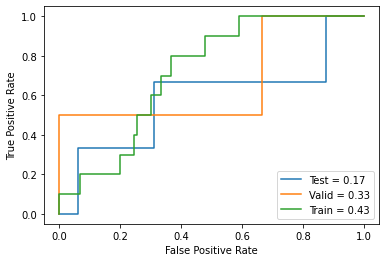

In [18]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 2)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 2)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

pred_test = log_reg.predict_proba(test_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]
pred_valid = log_reg.predict_proba(valid_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]
pred_train = log_reg.predict_proba(train_logit.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]

plot_roc_curve(true_y = (test_logit['TARGET'], valid_logit['TARGET'], train_logit['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

## LGBM

In [19]:
train_lgb = copy.deepcopy(train)
valid_lgb = copy.deepcopy(valid)
test_lgb = copy.deepcopy(test)

In [20]:
train_lgb = train_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

valid_lgb = valid_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

test_lgb = test_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

In [21]:
lgb_train = lgb.Dataset(data=train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train_lgb.TARGET)
lgb_valid = lgb.Dataset(data=valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid_lgb.TARGET)
lgb_test = lgb.Dataset(data=test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test_lgb.TARGET)

In [24]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}

model_lgb_base = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16742, number of negative: 192361
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.351320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6784
[LightGBM] [Info] Number of data points in the train set: 209103, number of used features: 361
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080066 -> initscore=-2.441453
[LightGBM] [Info] Start training from score -2.441453
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.747292	valid_1's auc: 0.732833
[100]	training's auc: 0.753475	valid_1's auc: 0.737504
[150]	training's auc: 0.761076	valid_1's auc: 0.743845
[200]	training's auc: 0.76818	valid_1's auc: 0.750264
[250]	training's auc: 0.774056	valid_1's auc: 0.755436
[300]	training's auc: 

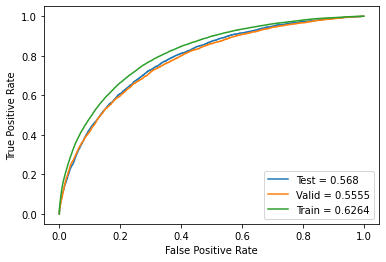

In [25]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_base.predict(test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_valid = model_lgb_base.predict(valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_train = model_lgb_base.predict(train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))

plot_roc_curve(true_y = (test_lgb['TARGET'], valid_lgb['TARGET'], train_lgb['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))